In [1]:
# import from skimage
from skimage.color import rgb2gray
from skimage.filters import sobel, sobel_h, sobel_v, prewitt, roberts, gaussian
from skimage.feature import canny
import skimage.io as io
import cv2 as cv
# import from matplotlib
import matplotlib.pyplot as plt

# import from numpy
import numpy as np

# import utils
from utils.commonfunctions import *


In [2]:
# img = io.imread("datasets/dataset_module1/01.jpg")

# read image 1.jpg
img = cv.imread('datasets/dataset_module1/01.jpg',0)
# colored_img = cv.imread('datasets/dataset_module1/01.jpg')
# img = cv.imread('datasets/dataset2_module1/4.jpg',0)

# convert to greyscale
grey_scale = img

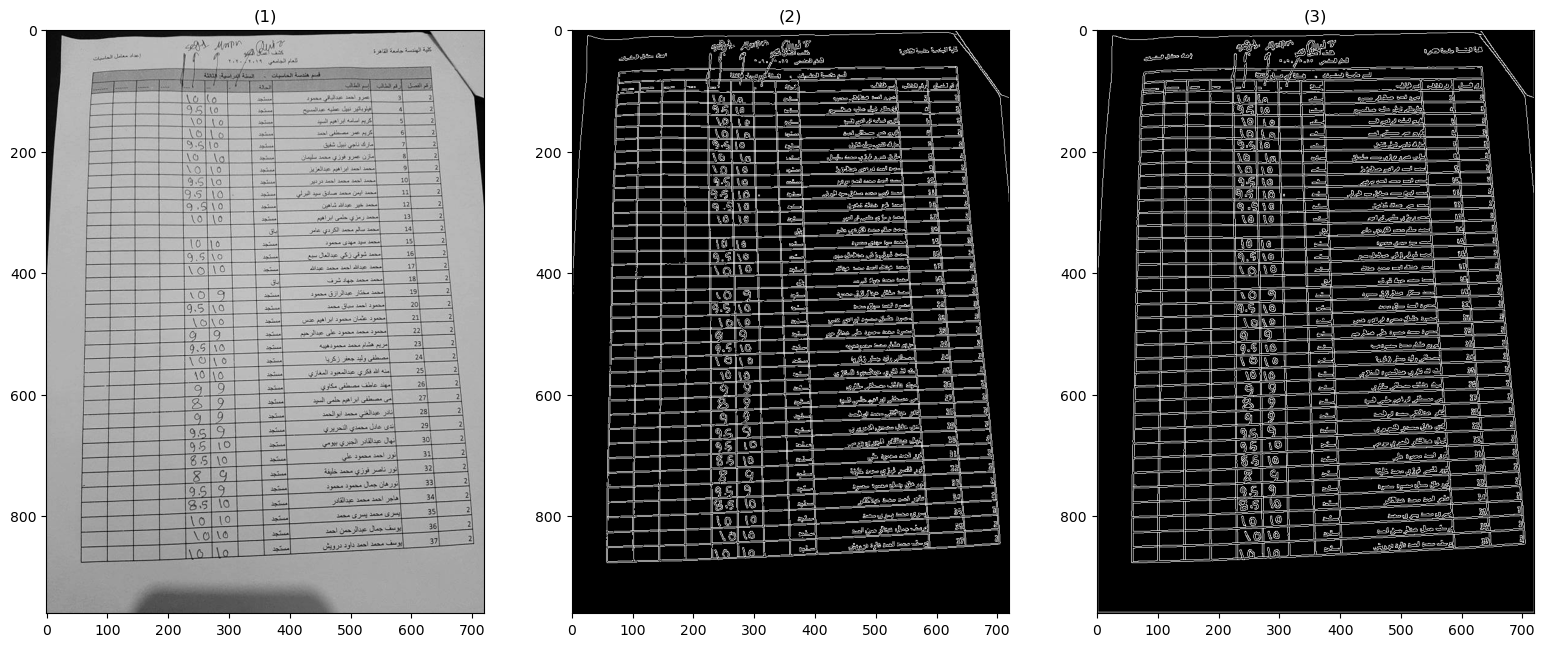

In [3]:
# use canny to detect edges
cannyEdges = cannyEdge(grey_scale)

# TODO: reomve print
show_images([grey_scale,cannyEdges,canny(grey_scale,sigma = 1)])

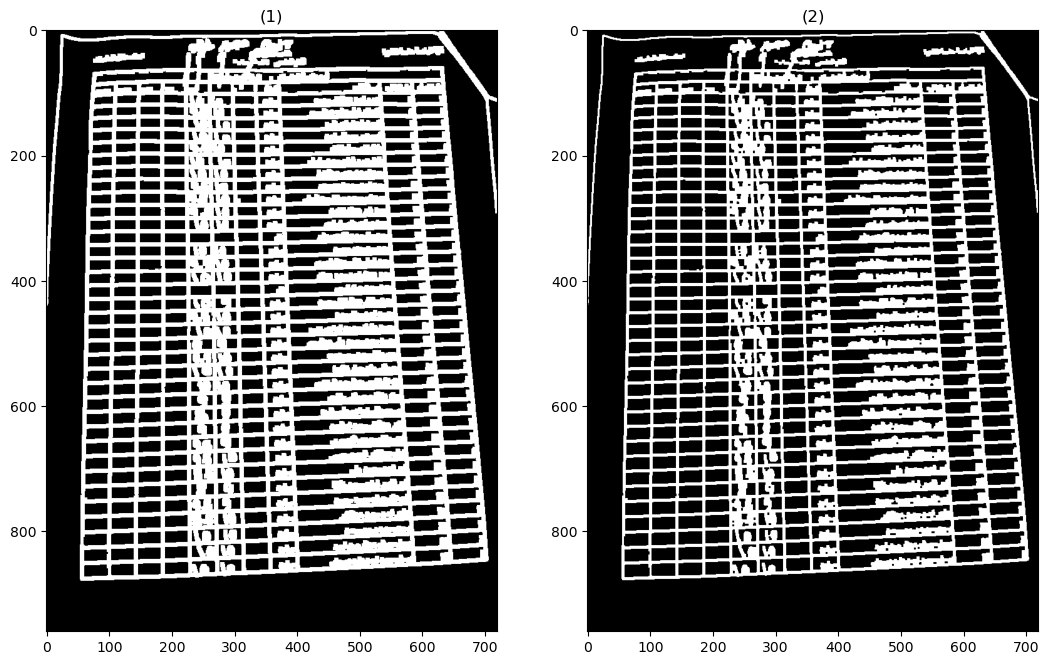

In [4]:
# Apply closing
# closing_kernel = np.ones((3,3))
# closing_img = closing(cannyEdges,closing_kernel)

dilate_kernel = np.ones((5,5))
erosion_kernel = np.ones((3,3))

dilated_img = dilate(cannyEdges,dilate_kernel)

closed_img = erode(dilated_img,erosion_kernel)

show_images([dilated_img,closed_img])

[[256  16]] [[258  16]]


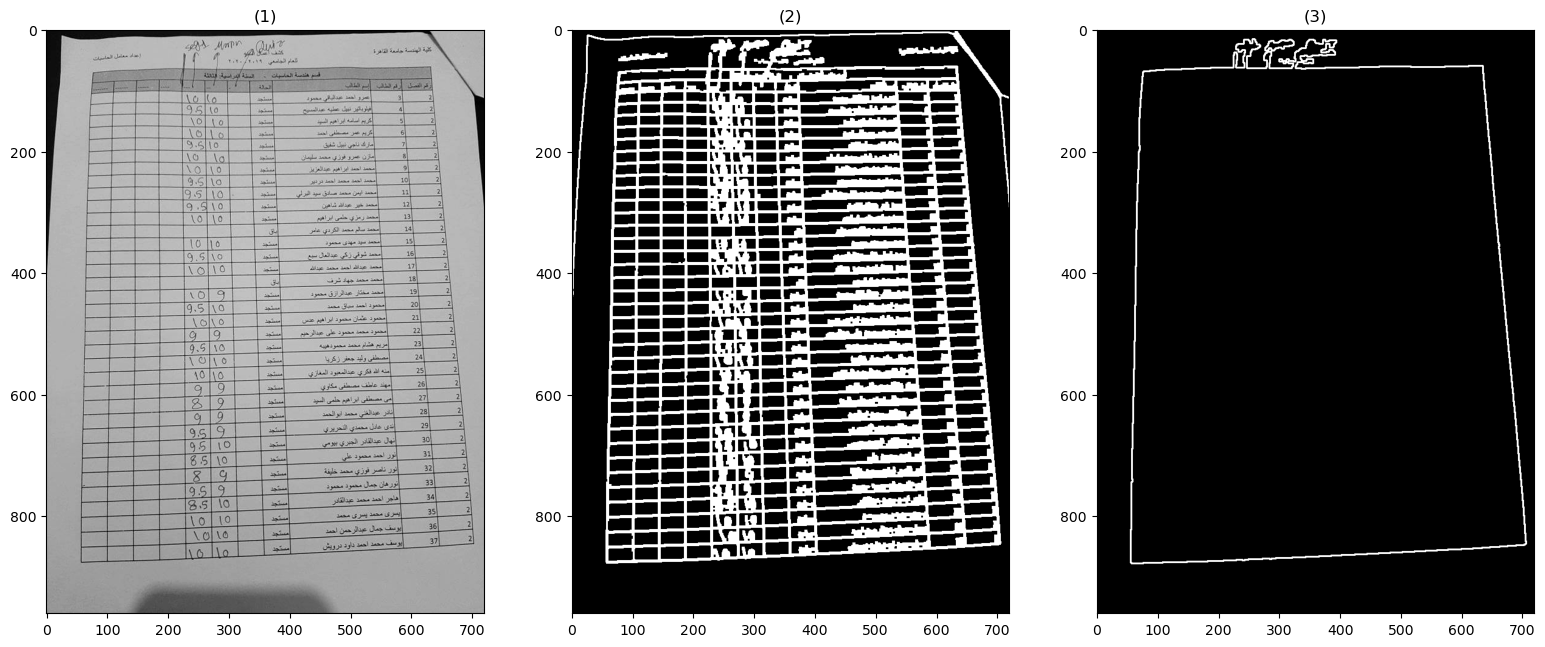

In [5]:
contours, hierarchy = cv.findContours(closed_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# take a copy for the original image
cpy_img = np.copy(img)

# get the biggest contour
c = max(contours, key = cv.contourArea)

print(c[0],c[len(c)-1])

# compute the bounding rectangle of the contour
x,y,w,h = cv.boundingRect(c)

black_img = np.zeros(cpy_img.shape)

# draw the bounding rectangle
# cpy_img = cv.rectangle(cpy_img,(x,y),(x+w,y+h),(0,255,0),2)

# draw contour
biggest_contour = cv.drawContours(black_img,[c],0,(255,255,255),2)

# display the image with bounding rectangle drawn on it
show_images(images = [img, closed_img, biggest_contour])

[[[ 75  70]]

 [[ 56 878]]

 [[704 847]]

 [[634  61]]]


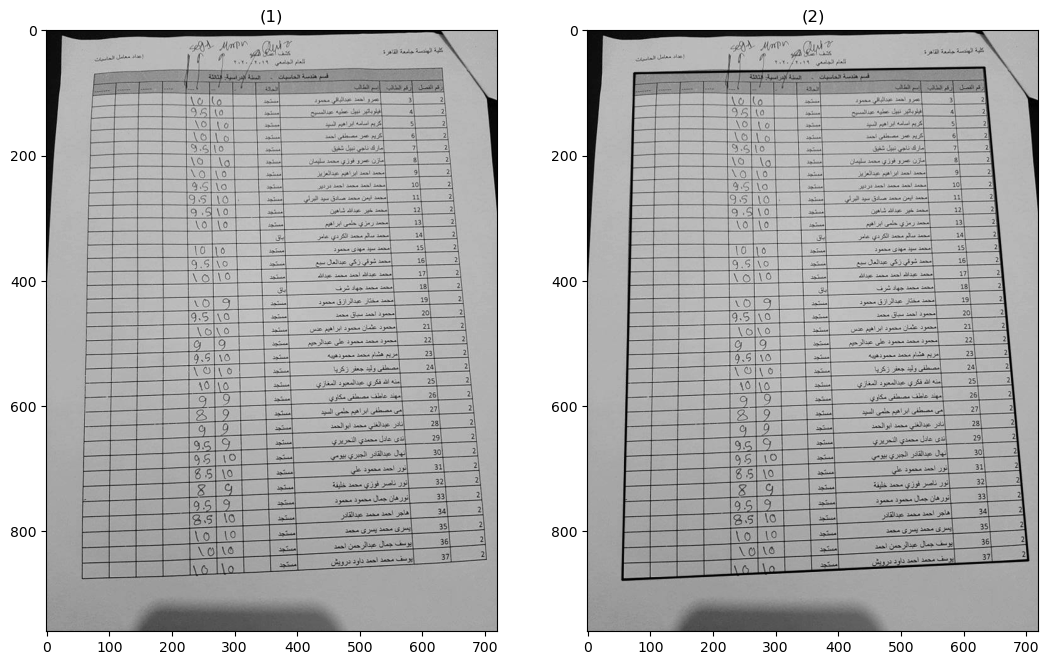

In [6]:
# limit contour to quadrilateral
peri = cv.arcLength(c, True)
corners = cv.approxPolyDP(c, 0.04 * peri, True)

print(corners)

# draw quadrilateral on input image from detected corners
result = img.copy()
cv.polylines(result, [corners], True, (0,0,255), 2, cv.LINE_AA)

show_images([img,result])
#########################
# dilate_kernel = np.ones((20,20))
# dilated_black_img = dilate(black_img,dilate_kernel)

# erosion_kernel = np.ones((10,10))

# closed_black_img = erode(dilated_black_img,erosion_kernel)

# lines = cv.HoughLinesP(closed_black_img.astype(np.uint8),1,np.pi/180,100,minLineLength=img.shape[0]/2,maxLineGap=10)

# white_img = np.zeros(closed_black_img.shape)
# cpy_img = img.copy()
# for line in lines:
#     x1,y1,x2,y2 = line[0]
#     cv.line(white_img,(x1,y1),(x2,y2),(255,255,255),2)



In [7]:
print(x,y,w,h)

top_left = corners[0][0]
top_right = corners[1][0]
bottom_left = corners[3][0]
bottom_right = corners[2][0]

print(top_left,top_right,bottom_left,bottom_right)


55 16 651 863
[75 70] [ 56 878] [634  61] [704 847]


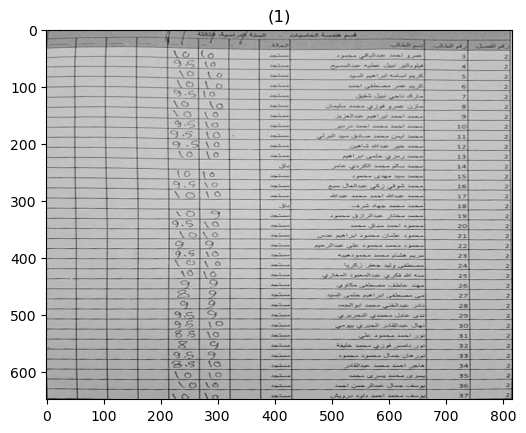

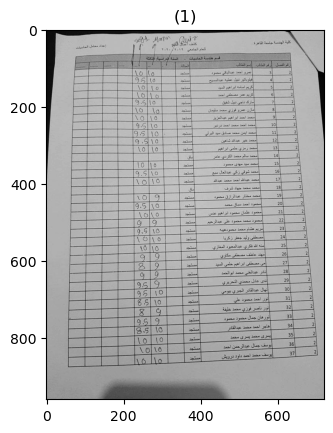

In [11]:
width = np.max([top_left[1],top_right[1],bottom_left[1],bottom_right[1]]) - np.min([top_left[1],top_right[1],bottom_left[1],bottom_right[1]]) 
height = np.max([top_left[0],top_right[0],bottom_left[0],bottom_right[0]]) - np.min([top_left[0],top_right[0],bottom_left[0],bottom_right[0]])
oldPoints = np.float32([top_left,bottom_left,top_right,bottom_right])
newPoints = np.float32([[0,0],[width,0],[0,height],[width,height]])
transformationMatrix = cv.getPerspectiveTransform(oldPoints,newPoints)
transormedImg = cv.warpPerspective(img,transformationMatrix,(width,height))

show_images(images = [transormedImg])
show_images(images = [img])